# Analysis of Sequentially Trained Models

Objectives:
1. Load the final models (Transformer+OCSVM, PRAE, PNN).
2. Evaluate on the held-out Test Day (Day 25).
3. Visualize anomaly scores and detect events.
4. Perform Root Cause Analysis on detected anomalies.

In [1]:
import os
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("..")

from PDMM import preprocessing as prep
from PDMM import machine_learning as ml
from PDMM import visualization as viz
from PDMM.pipeline import AnomalyDetectionPipeline, load_model, LazySequenceDataset

sys.modules['preprocessing'] = prep

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

Running on cuda


In [5]:
# Configuration
DATASET = 'TOTF'
SCALER = 'box-cox'
DATA_DIR = '../data/TOTF.PA-book'
MODEL_DIR = '../models'
TEST_DAY_INDEX = 24  # Day 25, 0 indexed
SEQ_LENGTH = 25
FIRST_HOUR_MINUTES = 60
FEATURE_SETS = ['base', 'tao', 'poutre', 'hawkes', 'ofi']
WARMUP_STEPS = 3000  # Match the warm-up used in training

# Load and Engineer Features for the Whole Day
files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith(('.csv', '.csv.gz'))])
test_file = files[TEST_DAY_INDEX]
print(f"Processing Test Data: {test_file}")

data_pipeline = AnomalyDetectionPipeline()
data_pipeline.load_data(os.path.join(DATA_DIR, test_file))

# Filter Pre-market
df = data_pipeline.raw_df
time_col = 'xltime'
base_date = np.floor(df[time_col].iloc[0])
open_fraction = 8.0 / 24.0
official_open = base_date + open_fraction

df = df[df[time_col] >= official_open].reset_index(drop=True)
data_pipeline.raw_df = df

# Feature Engineering (with warm-up trimming)
data_pipeline.engineer_features(FEATURE_SETS, warmup_steps=WARMUP_STEPS)

# Use trimmed df because of warm-up removal
df_trimmed = data_pipeline.raw_df

# Load Reference Config & Scaler
ref_config_path = f"{MODEL_DIR}/{DATASET}_{SCALER}_transformer_ocsvm_sequential_config.json"
with open(ref_config_path, 'r') as f: train_config = json.load(f)
trained_features = train_config['feature_names']

scaler_path = f"{MODEL_DIR}/{DATASET}_{SCALER}_transformer_ocsvm_sequential_scaler.pkl"
scaler = joblib.load(scaler_path)

# Align features and Scale
data_pipeline.processed_df = data_pipeline.processed_df[trained_features]
full_data_scaled = scaler.transform(data_pipeline.processed_df.values)

# Split into Morning (First Hour) and Rest of Day
time_factor = 1.0 / (24.0 * 60.0)
cutoff_time = df_trimmed[time_col].iloc[0] + (FIRST_HOUR_MINUTES * time_factor)

morning_mask = df_trimmed[time_col] < cutoff_time
morning_indices = np.where(morning_mask)[0]
rest_indices = np.where(~morning_mask)[0]

morning_data = full_data_scaled[morning_indices]
rest_data = full_data_scaled[rest_indices]

print(f"Morning Samples: {len(morning_data)}")
print(f"Rest of Day Samples: {len(rest_data)}")

# Create Datasets
morning_dataset = LazySequenceDataset(morning_data, SEQ_LENGTH)
rest_dataset = LazySequenceDataset(rest_data, SEQ_LENGTH)

morning_loader = torch.utils.data.DataLoader(morning_dataset, batch_size=128, shuffle=False)
rest_loader = torch.utils.data.DataLoader(rest_dataset, batch_size=128, shuffle=False)

Processing Test Data: 2015-01-06-TOTF.PA-book.csv.gz
Pipeline initialized on device: cuda
Loading data from ../data/TOTF.PA-book\2015-01-06-TOTF.PA-book.csv.gz...
Successfully loaded 1272556 rows.
Engineering features: ['base', 'tao', 'poutre', 'hawkes', 'ofi']...
Hawkes warm-up: Dropped first 3000 rows for EWMA stabilization.
Feature Engineering complete. Total features: 131
Morning Samples: 168602
Rest of Day Samples: 1099058


## Model Analysis: Transformer + OC-SVM


==================== TRANSFORMER_OCSVM ====================
Pipeline initialized on device: cuda

Analyzing Morning (First Hour)...
POT - risk=0.001 Threshold: -0.3377
Detected 142 anomalies out of 168577 samples (0.08%).


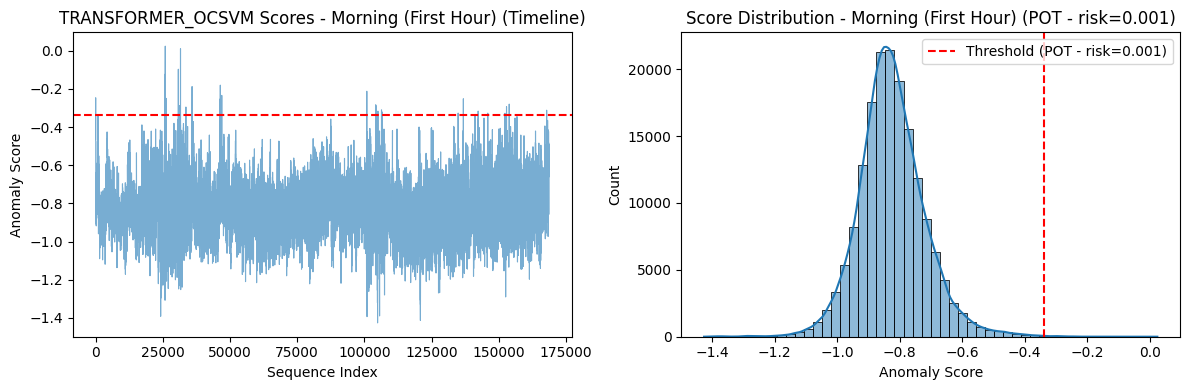

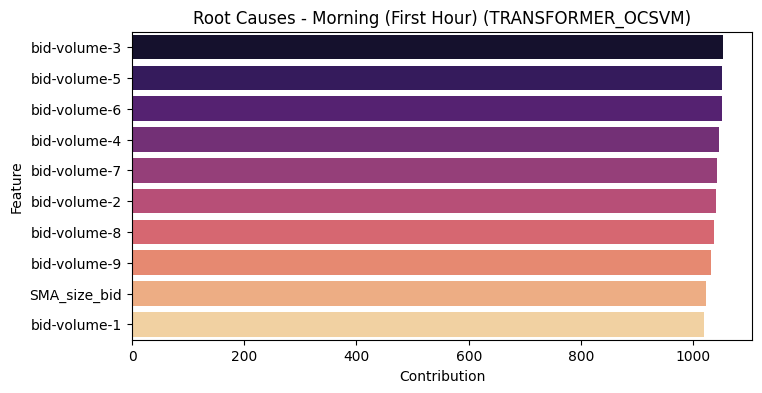


Analyzing Rest of Day...
POT - risk=0.001 Threshold: 0.6871
Detected 1401 anomalies out of 1099033 samples (0.13%).


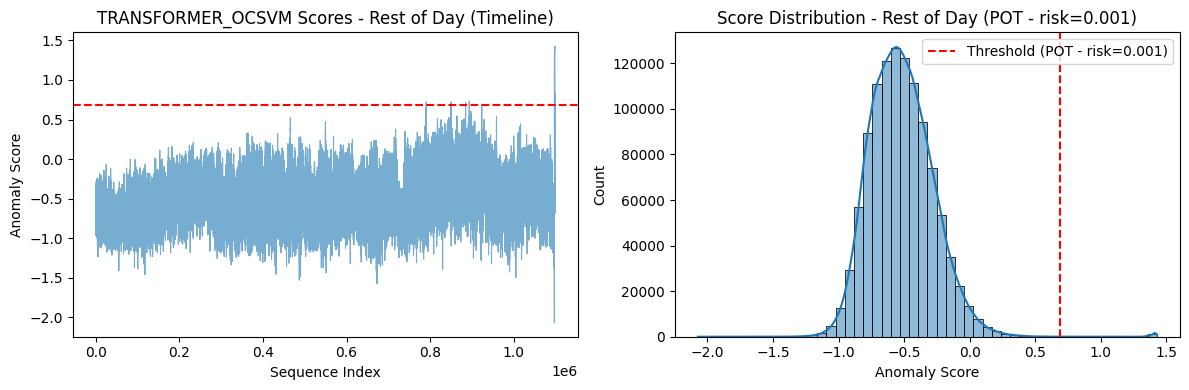

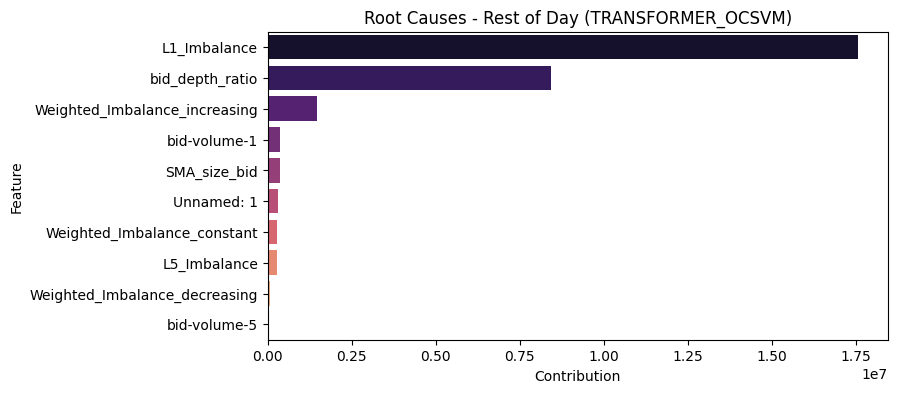

In [6]:
MODEL_NAME = 'transformer_ocsvm'
print(f"\n{'='*20} {MODEL_NAME.upper()} {'='*20}")

config_path = f"{MODEL_DIR}/{DATASET}_{SCALER}_{MODEL_NAME}_sequential_config.json"
weights_path = f"{MODEL_DIR}/{DATASET}_{SCALER}_{MODEL_NAME}_sequential_weights.pth"
detector_path = f"{MODEL_DIR}/{DATASET}_{SCALER}_{MODEL_NAME}_sequential_ocsvm_detector.pkl"
scaler_path = f"{MODEL_DIR}/{DATASET}_{SCALER}_{MODEL_NAME}_sequential_latent_scaler.pkl"
    
# Load
dummy_df = data_pipeline.processed_df.iloc[:100]
pipeline, cfg = load_model(config_path, dummy_df, data_pipeline.feature_names)
pipeline.model.load_state_dict(torch.load(weights_path, map_location=device))
pipeline.detector = joblib.load(detector_path)
pipeline.latent_scaler = joblib.load(scaler_path)
pipeline.model.eval()



# Analyze Morning
ml.analyze_subset(pipeline, morning_loader, "Morning (First Hour)", MODEL_NAME, trained_features, save_path=f"../results/analysis/{DATASET}_{SCALER}_{MODEL_NAME}_sequential_morning")

# Analyze Rest of Day
ml.analyze_subset(pipeline, rest_loader, "Rest of Day", MODEL_NAME, trained_features, save_path=f"../results/analysis/{DATASET}_{SCALER}_{MODEL_NAME}_sequential_rest")

## Model Analysis: Probabilistic Neural Network (PNN)


==================== PNN ====================
Pipeline initialized on device: cuda

Analyzing Morning (First Hour)...
POT - risk=0.001 Threshold: -inf
Detected 168577 anomalies out of 168577 samples (100.00%).


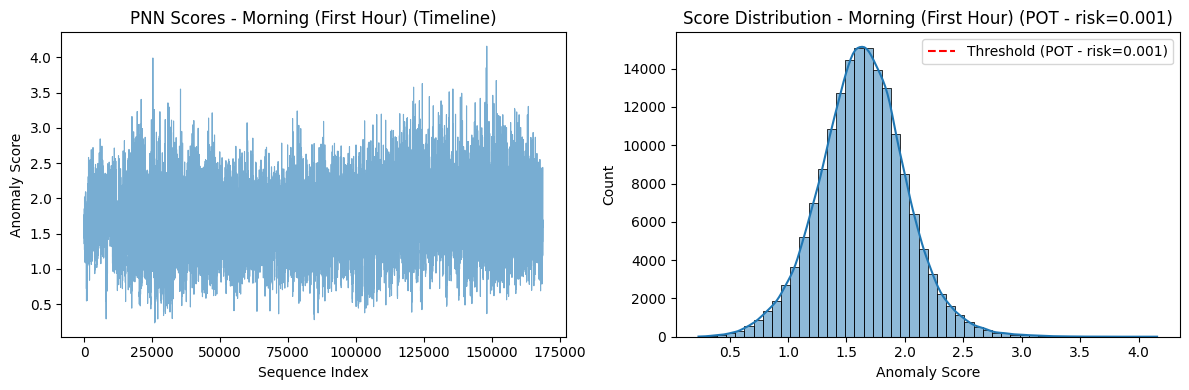

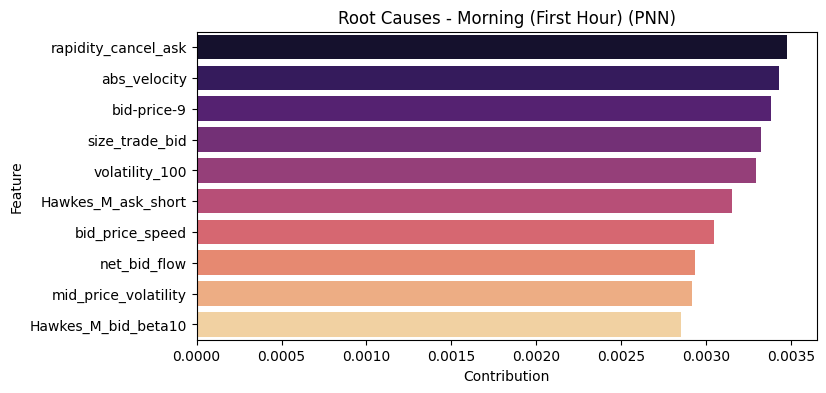


Analyzing Rest of Day...
POT - risk=0.001 Threshold: 2.7117
Detected 811 anomalies out of 1099033 samples (0.07%).


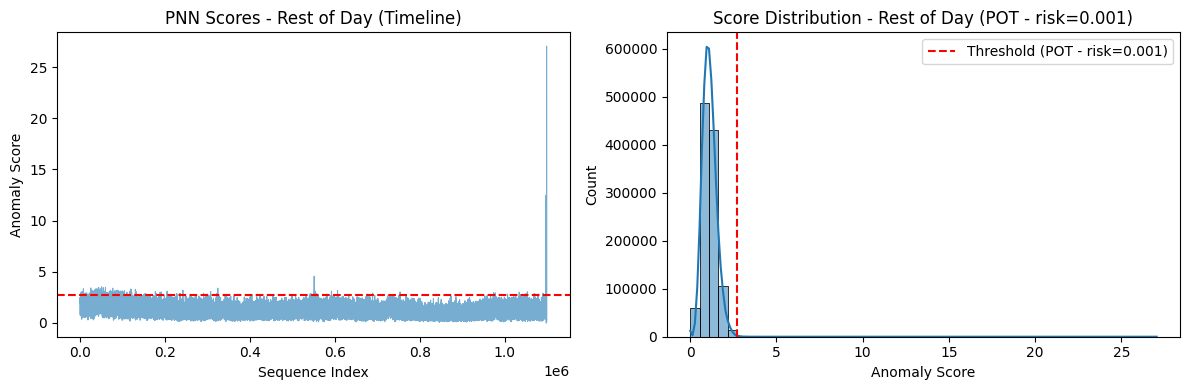

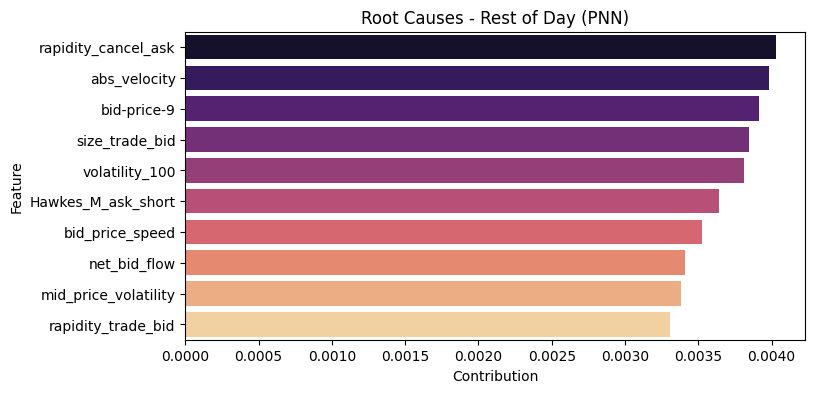

In [7]:
MODEL_NAME = 'pnn'
print(f"\n{'='*20} {MODEL_NAME.upper()} {'='*20}")

config_path = f"{MODEL_DIR}/{DATASET}_{SCALER}_{MODEL_NAME}_sequential_config.json"
weights_path = f"{MODEL_DIR}/{DATASET}_{SCALER}_{MODEL_NAME}_sequential_weights.pth"

# Load
pipeline, cfg = load_model(config_path, dummy_df, data_pipeline.feature_names)
pipeline.model.load_state_dict(torch.load(weights_path, map_location=device))
pipeline.model.eval()

# Analyze Morning
ml.analyze_subset(pipeline, morning_loader, "Morning (First Hour)", MODEL_NAME, trained_features, save_path=f"../results/analysis/{DATASET}_{SCALER}_{MODEL_NAME}_sequential_morning")

# Analyze Rest of Day
ml.analyze_subset(pipeline, rest_loader, "Rest of Day", MODEL_NAME, trained_features, save_path=f"../results/analysis/{DATASET}_{SCALER}_{MODEL_NAME}_sequential_rest")

## Model Analysis: Probabilistic Robust Autoencoder (PRAE)


==================== PRAE ====================


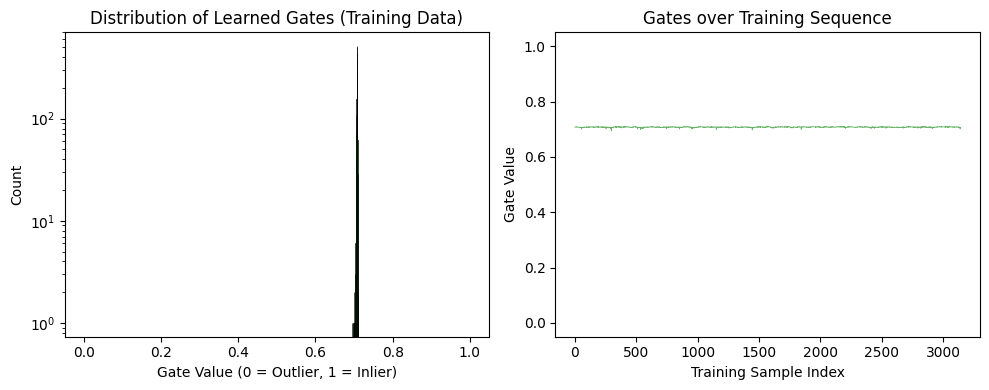

Total Training Samples: 3142
Samples treated as outliers (mu < 0.5): 0 (0.00%)
Pipeline initialized on device: cuda

Analyzing Morning (First Hour)...
POT - risk=0.001 Threshold: 248.6516
Detected 228 anomalies out of 168577 samples (0.14%).


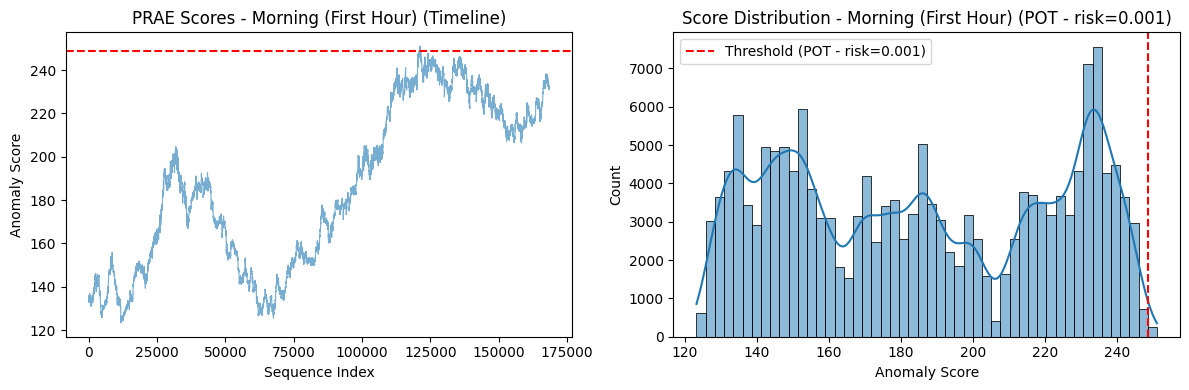

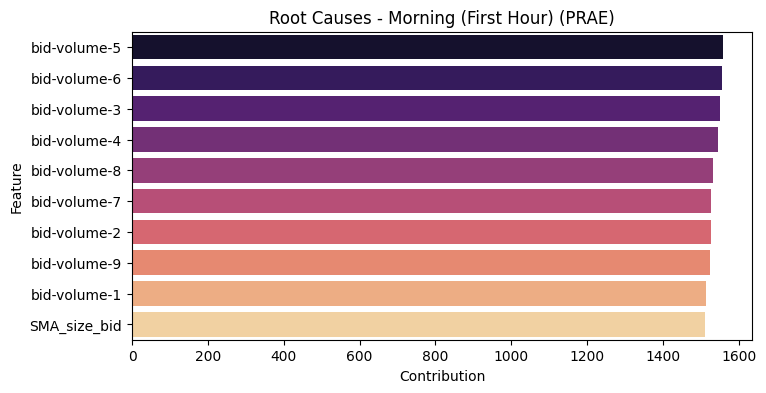


Analyzing Rest of Day...
POT - risk=0.001 Threshold: 508.3085
Detected 1379 anomalies out of 1099033 samples (0.13%).


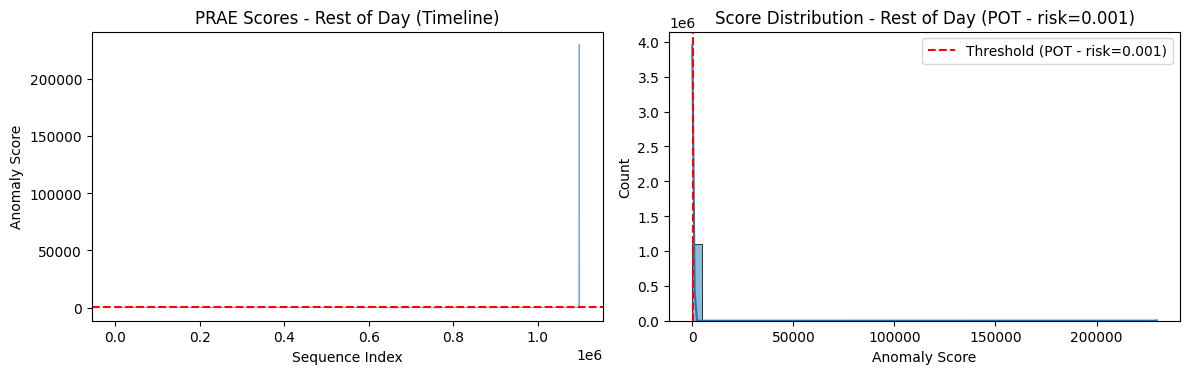

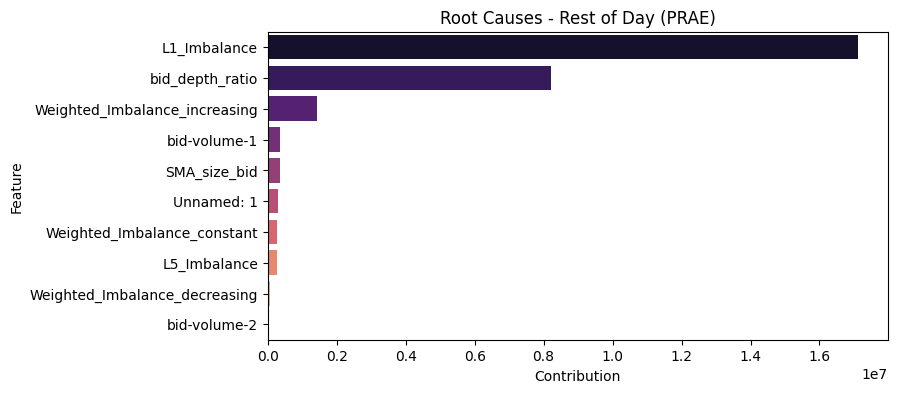

In [8]:
MODEL_NAME = 'prae'
print(f"\n{'='*20} {MODEL_NAME.upper()} {'='*20}")

config_path = f"{MODEL_DIR}/{DATASET}_{SCALER}_{MODEL_NAME}_sequential_config.json"
weights_path = f"{MODEL_DIR}/{DATASET}_{SCALER}_{MODEL_NAME}_sequential_weights.pth"

# Analyze Learned Gates
state_dict = torch.load(weights_path, map_location=device)

raw_mu = state_dict['mu'].cpu()
gates = torch.sigmoid(raw_mu).numpy().flatten()

# Visualization
plt.figure(figsize=(10, 4))
    
# Histogram
plt.subplot(1, 2, 1)
sns.histplot(gates, bins=50, kde=False, color='green')
plt.title("Distribution of Learned Gates (Training Data)")
plt.xlabel("Gate Value (0 = Outlier, 1 = Inlier)")
plt.xlim(-0.05, 1.05)
plt.yscale('log') # Log scale helps see the small number of outliers (near 0)
    
# Scatter plot
plt.subplot(1, 2, 2)
plt.plot(gates, alpha=0.6, linewidth=0.5, color='green')
plt.title("Gates over Training Sequence")
plt.xlabel("Training Sample Index")
plt.ylabel("Gate Value")
plt.ylim(-0.05, 1.05)
    
plt.tight_layout()
plt.savefig(f"../results/analysis/{DATASET}_{SCALER}_{MODEL_NAME}_sequential_learned_gates.png", dpi=300)
plt.show()
    
print(f"Total Training Samples: {len(gates)}")
print(f"Samples treated as outliers (mu < 0.5): {np.sum(gates < 0.5)} ({np.sum(gates < 0.5)/len(gates):.2%})")


# Load Model for Inference
# Initialize Pipeline
dummy_df = data_pipeline.processed_df.iloc[:100]
pipeline, cfg = load_model(config_path, dummy_df, data_pipeline.feature_names)

# Load weights
state_dict = torch.load(weights_path, map_location=device)
if 'mu' in state_dict: del state_dict['mu']
pipeline.model.load_state_dict(state_dict, strict=False)
pipeline.model.eval()

# Analyze Morning (First Hour)
ml.analyze_subset(pipeline, morning_loader, "Morning (First Hour)", MODEL_NAME, trained_features, save_path=f"../results/analysis/{DATASET}_{SCALER}_{MODEL_NAME}_sequential_morning")

# Analyze Rest of Day
ml.analyze_subset(pipeline, rest_loader, "Rest of Day", MODEL_NAME, trained_features, save_path=f"../results/analysis/{DATASET}_{SCALER}_{MODEL_NAME}_sequential_rest")